# Parkinson's Disease Classification | BAKPEN KOMBAT

This project uses a fine-tuned VGG16 convolutional neural network to classify Parkinson's Disease from PET scan brain images. The model is trained to distinguish between PD and Non-PD cases by learning relevant patterns in the scans. For interpretability, Grad-CAM and CAM techniques are applied to visualize the brain regions most influential in the model's predictions, using both single-layer and multi-layer activation mapping. 

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shayalvaghasiya_ntua_prakinson_path = kagglehub.dataset_download('shayalvaghasiya/ntua-prakinson')
shauryadevpathak_parkinsons_path = kagglehub.dataset_download('shauryadevpathak/parkinsons')
shauryadevpathak_vgg16_parkinsons_pytorch_default_1_path = kagglehub.model_download('shauryadevpathak/vgg16_parkinsons/PyTorch/default/1')

print('Data source import complete.')


In [ ]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
data_dir = "/kaggle/input/ntua-prakinson/ntua-parkinson-dataset-master"

def load_images_and_labels(data_dir, target_size=(224, 224)):
    images = []
    labels = []

    for label_folder in ['PD Patients', 'Non PD Patients']:
        label_path = os.path.join(data_dir, label_folder)
        label = 1 if label_folder == 'PD' else 0

        # Traverse each person’s folder
        for person_folder in os.listdir(label_path):
            person_path_fol = os.path.join(label_path, person_folder, '0.DAT/')
            if os.path.isdir(person_path_fol):
                for person_path in os.listdir(person_path_fol):
                    person_path = os.path.join(person_path_fol, person_path)
                    # print(person_path)
                    if os.path.exists(person_path):
                        # print(person_path)
                        for img_file in os.listdir(person_path):
                            # print(img_file)
                            img_path = os.path.join(person_path, img_file)
                            img = cv2.imread(img_path)
                            if img is not None:
                                img = cv2.resize(img, target_size)
                                images.append(img)
                                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

images, labels = load_images_and_labels(data_dir)

In [ ]:
class ParkinsonsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
    transforms.RandomRotation(15),  # Randomly rotate the image
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.Resize((224, 224)),  # Resize to VGG16 input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
train_dataset = ParkinsonsDataset(train_images, train_labels, transform=train_transform)
val_dataset = ParkinsonsDataset(val_images, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = models.vgg16(pretrained=True)

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
model.classifier[5] = nn.Dropout(0.5)
model.classifier[6] = nn.Linear(4096, 1)
model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()  # Convert labels to float for BCEWithLogitsLoss

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)  # Squeeze to remove extra dimensions

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid for binary classification
        correct += (predicted.squeeze() == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted.squeeze() == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total

    # Print statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/2], Train Loss: 0.0388, Train Acc: 98.51%, Val Loss: 0.0000, Val Acc: 100.00%
Epoch [2/2], Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%


In [ ]:
#torch.save(torch.save(model.state_dict(), 'parkinsons_vgg16_cam_complete.pth'))

tensor([[6.4186]], device='cuda:0', grad_fn=<AddmmBackward0>)


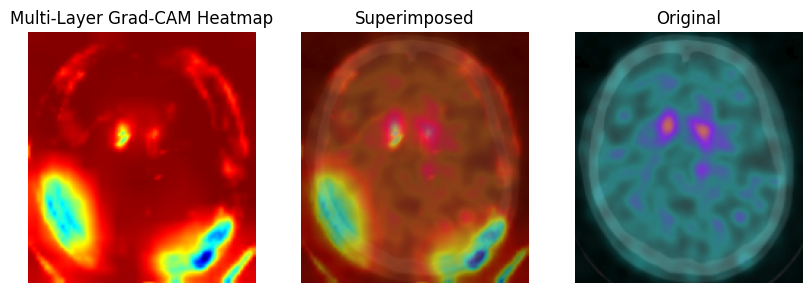

In [ ]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load VGG16 pretrained model
model = torch.load('/kaggle/input/vgg16_parkinsons/pytorch/default/1/parkinsons_vgg16_cam_complete.pth', weights_only=False)
model = model.to(device)
model.eval()

# Prepare input image
img = cv2.imread("/kaggle/input/parkinsons/parkinsons/PD/Subject8/0.DAT/s1/001.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_size = img.shape[:2]
input_image = cv2.resize(img, (224, 224))
input_image = np.transpose(input_image, (2, 0, 1)) / 255.0
input_image = torch.tensor(input_image, dtype=torch.float32).unsqueeze(0).to(device)

# Hooks for capturing features and gradients
features = {}
gradients = {}

def forward_hook(layer_name):
    def hook(module, input, output):
        features[layer_name] = output
    return hook

def backward_hook(layer_name):
    def hook(module, grad_input, grad_output):
        gradients[layer_name] = grad_output[0]
    return hook

# Select multiple layers
target_layers = {
    "layer_1": model.features[0],   # Very early layer
    "layer_2": model.features[2],   # Early layer
    "layer_3": model.features[5],   # Early convolutional layer
    "layer_4": model.features[7],   # Transition to middle layers
    "layer_5": model.features[10],  # Middle layer
    "layer_6": model.features[12],  # Deeper middle layer
    "layer_7": model.features[14],  # Middle-to-deep layer
    "layer_8": model.features[17],  # Transition to deeper layers
    "layer_9": model.features[19],  # Deep layer
    "layer_10": model.features[24], # Deeper layer
    "layer_11": model.features[26], # Deep layer
    "layer_12": model.features[28], # Approaching late layers
}

# Attach hooks to the selected layers
for name, layer in target_layers.items():
    layer.register_forward_hook(forward_hook(name))
    layer.register_backward_hook(backward_hook(name))

# Forward pass
output = model(input_image)
class_idx = torch.argmax(output).item()

# Backward pass for the target class
model.zero_grad()
output[0, class_idx].backward()

# Generate Grad-CAM using gradients from multiple layers
def generate_multi_layer_gradcam(features, gradients, target_layers):
    combined_cam = None

    for layer_name in target_layers:
        # Get features and gradients for the layer
        layer_features = features[layer_name]
        layer_gradients = gradients[layer_name]

        # Calculate weights using global average pooling
        weights = torch.mean(layer_gradients, dim=(2, 3), keepdim=True)

        # Calculate Grad-CAM for the layer
        cam = torch.sum(weights * layer_features, dim=1).squeeze(0).cpu().detach().numpy()
        cam = np.maximum(cam, 0)  # Apply ReLU
        cam = cv2.resize(cam, (224, 224))

        # Normalize the CAM
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        # Combine CAMs from different layers (e.g., sum or average)
        if combined_cam is None:
            combined_cam = cam
        else:
            combined_cam += cam  # Sum the contributions

    # Normalize the final combined CAM
    combined_cam = (combined_cam - combined_cam.min()) / (combined_cam.max() - combined_cam.min() + 1e-8)
    return combined_cam

# Generate multi-layer Grad-CAM
cam = generate_multi_layer_gradcam(features, gradients, target_layers)

# Resize the heatmap to match the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap_resized = cv2.resize(heatmap, (original_size[1], original_size[0]))

# Superimpose the heatmap on the original image
superimposed = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.5, heatmap_resized, 0.5, 0)

print(output)
# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Multi-Layer Grad-CAM Heatmap")
plt.imshow(heatmap_resized)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Superimposed")
plt.imshow(superimposed)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("Original")
plt.imshow(img)
plt.show()


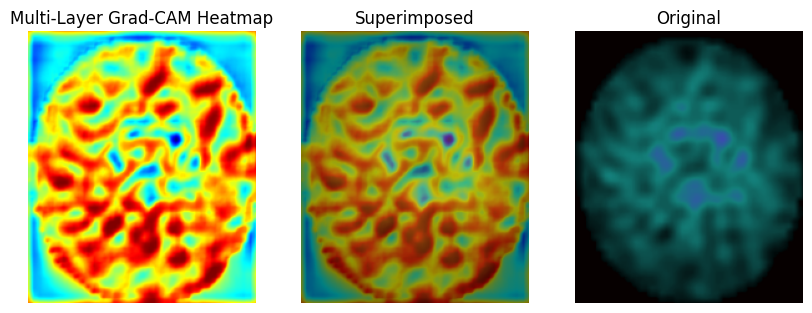

In [ ]:
img = cv2.imread("/kaggle/input/parkinsons/parkinsons/non-PD/Subject3/0.DAT/s1/001.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_size = img.shape[:2]
input_image = cv2.resize(img, (224, 224))
input_image = np.transpose(input_image, (2, 0, 1)) / 255.0
input_image = torch.tensor(input_image, dtype=torch.float32).unsqueeze(0).to(device)

# Hooks for capturing features and gradients
features = {}
gradients = {}

def forward_hook(layer_name):
    def hook(module, input, output):
        features[layer_name] = output
    return hook

def backward_hook(layer_name):
    def hook(module, grad_input, grad_output):
        gradients[layer_name] = grad_output[0]
    return hook

# Select multiple layers
target_layers = {
    "layer_1": model.features[0],   # Very early layer
    "layer_2": model.features[2],   # Early layer
    "layer_3": model.features[5],   # Early convolutional layer
    "layer_4": model.features[7],   # Transition to middle layers
    "layer_5": model.features[10],  # Middle layer
    "layer_6": model.features[12],  # Deeper middle layer
    "layer_7": model.features[14],  # Middle-to-deep layer
    "layer_8": model.features[17],  # Transition to deeper layers
    "layer_9": model.features[19],  # Deep layer
    "layer_10": model.features[24], # Deeper layer
    "layer_11": model.features[26], # Deep layer
    "layer_12": model.features[28], # Approaching late layers
}

# Attach hooks to the selected layers
for name, layer in target_layers.items():
    layer.register_forward_hook(forward_hook(name))
    layer.register_backward_hook(backward_hook(name))

# Forward pass
output = model(input_image)
class_idx = torch.argmax(output).item()

# Backward pass for the target class
model.zero_grad()
output[0, class_idx].backward()

# Generate multi-layer Grad-CAM
cam = generate_multi_layer_gradcam(features, gradients, target_layers)

# Resize the heatmap to match the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap_resized = cv2.resize(heatmap, (original_size[1], original_size[0]))

# Superimpose the heatmap on the original image
superimposed = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.5, heatmap_resized, 0.5, 0)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Multi-Layer Grad-CAM Heatmap")
plt.imshow(heatmap_resized)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Superimposed")
plt.imshow(superimposed)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("Original")
plt.imshow(img)
plt.show()

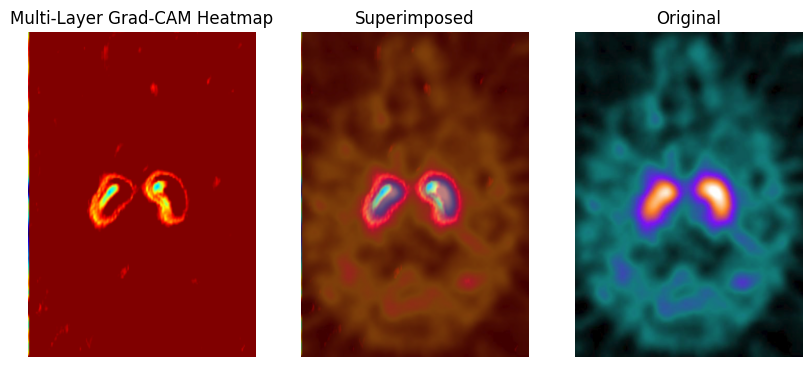

In [ ]:
img = cv2.imread("/kaggle/input/parkinsons/parkinsons/non-PD/Subject2/0.DAT/s1/001.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_size = img.shape[:2]
input_image = cv2.resize(img, (224, 224))
input_image = np.transpose(input_image, (2, 0, 1)) / 255.0
input_image = torch.tensor(input_image, dtype=torch.float32).unsqueeze(0).to(device)

# Hooks for capturing features and gradients
features = {}
gradients = {}

def forward_hook(layer_name):
    def hook(module, input, output):
        features[layer_name] = output
    return hook

def backward_hook(layer_name):
    def hook(module, grad_input, grad_output):
        gradients[layer_name] = grad_output[0]
    return hook

# Select multiple layers
target_layers = {
    "layer_1": model.features[0]  # Very early layer
}

# Attach hooks to the selected layers
for name, layer in target_layers.items():
    layer.register_forward_hook(forward_hook(name))
    layer.register_backward_hook(backward_hook(name))

# Forward pass
output = model(input_image)
class_idx = torch.argmax(output).item()

# Backward pass for the target class
model.zero_grad()
output[0, class_idx].backward()

# Generate multi-layer Grad-CAM
cam = generate_multi_layer_gradcam(features, gradients, target_layers)

# Resize the heatmap to match the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap_resized = cv2.resize(heatmap, (original_size[1], original_size[0]))

# Superimpose the heatmap on the original image
superimposed = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.5, heatmap_resized, 0.5, 0)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Multi-Layer Grad-CAM Heatmap")
plt.imshow(heatmap_resized)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Superimposed")
plt.imshow(superimposed)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("Original")
plt.imshow(img)
plt.show()

# CAM

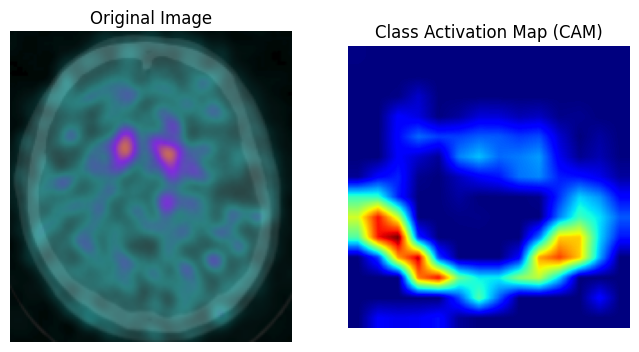

In [ ]:
model = torch.load('/kaggle/input/vgg16_parkinsons/pytorch/default/1/parkinsons_vgg16_cam_complete.pth', weights_only=False)
model = model.to(device)
model.eval()
target_layer = model.features[28]  # 'block5_conv3' is at index 28

feature_map = None

def hook_fn(module, input, output):
    global feature_map
    feature_map = output


hook = target_layer.register_forward_hook(hook_fn)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


img_path = '/kaggle/input/parkinsons/parkinsons/PD/Subject8/0.DAT/s1/001.png'
img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0).to(device)

output = model(img_tensor)
class_idx = torch.argmax(output).item()
class_weights = model.classifier[6].weight.data.to(device)


target_class_weight = class_weights[class_idx]
cam = torch.zeros(feature_map.shape[2:], dtype=torch.float32, device=device)

for i in range(feature_map.shape[1]):
    cam += target_class_weight[i] * feature_map[0, i, :, :]

cam = F.relu(cam)

cam = cam - cam.min()
cam = cam / cam.max()
cam = cam.unsqueeze(0).unsqueeze(0)  # Add channel dimension for compatibility
cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
cam = cam.squeeze().detach().cpu().numpy()

# Plot the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Plot the CAM heatmap
plt.subplot(1, 2, 2)
plt.imshow(cam, cmap='jet')
plt.title("Class Activation Map (CAM)")
plt.axis('off')

plt.show()


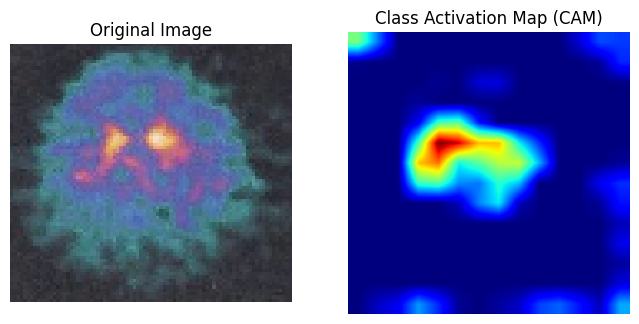

In [ ]:
model = torch.load('/kaggle/input/vgg16_parkinsons/pytorch/default/1/parkinsons_vgg16_cam_complete.pth', weights_only=False)
model = model.to(device)
model.eval()
target_layer = model.features[28]  # 'block5_conv3' is at index 28

feature_map = None

def hook_fn(module, input, output):
    global feature_map
    feature_map = output


hook = target_layer.register_forward_hook(hook_fn)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


img_path = '/kaggle/input/parkinsons/parkinsons/PD/Subject4/0.DAT/s1/001.png'
img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0).to(device)

output = model(img_tensor)
class_idx = torch.argmax(output).item()
class_weights = model.classifier[6].weight.data.to(device)


target_class_weight = class_weights[class_idx]
cam = torch.zeros(feature_map.shape[2:], dtype=torch.float32, device=device)

for i in range(feature_map.shape[1]):
    cam += target_class_weight[i] * feature_map[0, i, :, :]

cam = F.relu(cam)

cam = cam - cam.min()
cam = cam / cam.max()
cam = cam.unsqueeze(0).unsqueeze(0)  # Add channel dimension for compatibility
cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
cam = cam.squeeze().detach().cpu().numpy()

# Plot the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Plot the CAM heatmap
plt.subplot(1, 2, 2)
plt.imshow(cam, cmap='jet')
plt.title("Class Activation Map (CAM)")
plt.axis('off')

plt.show()


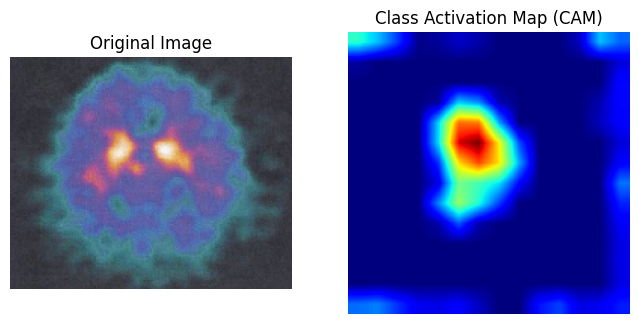

In [ ]:
model = torch.load('/kaggle/input/vgg16_parkinsons/pytorch/default/1/parkinsons_vgg16_cam_complete.pth', weights_only=False)
model = model.to(device)
model.eval()
target_layer = model.features[28]  # 'block5_conv3' is at index 28

feature_map = None

def hook_fn(module, input, output):
    global feature_map
    feature_map = output


hook = target_layer.register_forward_hook(hook_fn)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


img_path = '/kaggle/input/parkinsons/parkinsons/PD/Subject4/0.DAT/s2/001.png'
img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0).to(device)

output = model(img_tensor)
class_idx = torch.argmax(output).item()
class_weights = model.classifier[6].weight.data.to(device)


target_class_weight = class_weights[class_idx]
cam = torch.zeros(feature_map.shape[2:], dtype=torch.float32, device=device)

for i in range(feature_map.shape[1]):
    cam += target_class_weight[i] * feature_map[0, i, :, :]

cam = F.relu(cam)

cam = cam - cam.min()
cam = cam / cam.max()
cam = cam.unsqueeze(0).unsqueeze(0)  # Add channel dimension for compatibility
cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
cam = cam.squeeze().detach().cpu().numpy()

# Plot the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Plot the CAM heatmap
plt.subplot(1, 2, 2)
plt.imshow(cam, cmap='jet')
plt.title("Class Activation Map (CAM)")
plt.axis('off')

plt.show()
